# Diabetes Detection

Wenshan Zhang, Pengyuan Wei, Yujun Ma, Wenrui Wu, Yinghao Wang

Western University

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

# Data preprocessing and pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV
)
from sklearn.datasets import make_circles

# Model and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (
    make_scorer, confusion_matrix, accuracy_score, f1_score, 
    precision_score, recall_score, roc_curve, precision_recall_curve, auc, average_precision_score
)


import os
os.environ['MKL_SERVICE_FORCE_INTEL'] = '1'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Part1: Data preprocess


Zeros in all features except "Pregnancies" are considered abnormal based on medical knowledge, they might represent missing value or simply caused by measurement error. Removing any rows where features other than “Pregnancies” have a value of zero would result in significant data loss, form 768 to 392. 

In [2]:
df = pd.read_csv('diabetes.csv')
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
columns_with_abnormal_values = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# calculate the number of row left after remove abnormal value
data_no_abnormal = df[(df[columns_with_abnormal_values] != 0).all(axis=1)]
data_no_abnormal.shape[0]

392

Since features such as "Insulin" and "SKinThickness" are right skew distributed and contain outliers, we decide to use median imputation.

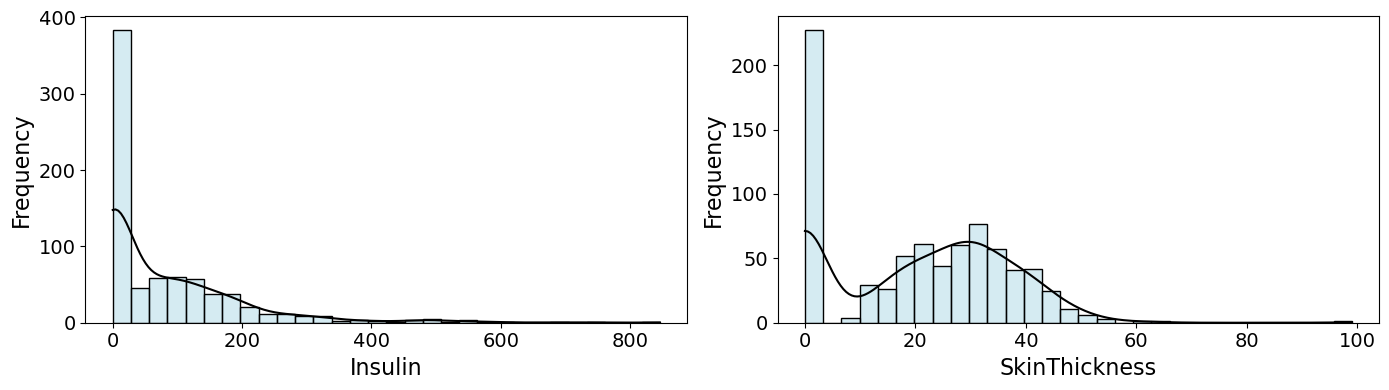

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# distribution of Insulin
sns.histplot(df['Insulin'], bins=30, ax=axes[0], color='lightblue', edgecolor='black', kde=True)
axes[0].lines[0].set_color('black') 
axes[0].set_xlabel('Insulin', fontsize=16)
axes[0].set_ylabel('Frequency', fontsize=16)
axes[0].tick_params(axis='both', labelsize=14)

# distribution of SkinThickness
sns.histplot(df['SkinThickness'], bins=30, ax=axes[1], color='lightblue', edgecolor='black', kde=True)
axes[1].lines[0].set_color('black') 
axes[1].set_xlabel('SkinThickness', fontsize=16)
axes[1].set_ylabel('Frequency', fontsize=16)
axes[1].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()



In [5]:
# median imputation
# copy data because we don't want to change the original data set
df_clean = df.copy()
col_contain_0 = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for column in col_contain_0:
    # find minmum value in each column except 0
    min_value = df_clean[df_clean[column] != 0][column].median()
    # replace 0 with minimum value
    df_clean[column] = df_clean[column].replace(0, min_value)
df_clean.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Part2: Visualization

### 2.1 	Relationship between response and single predictor

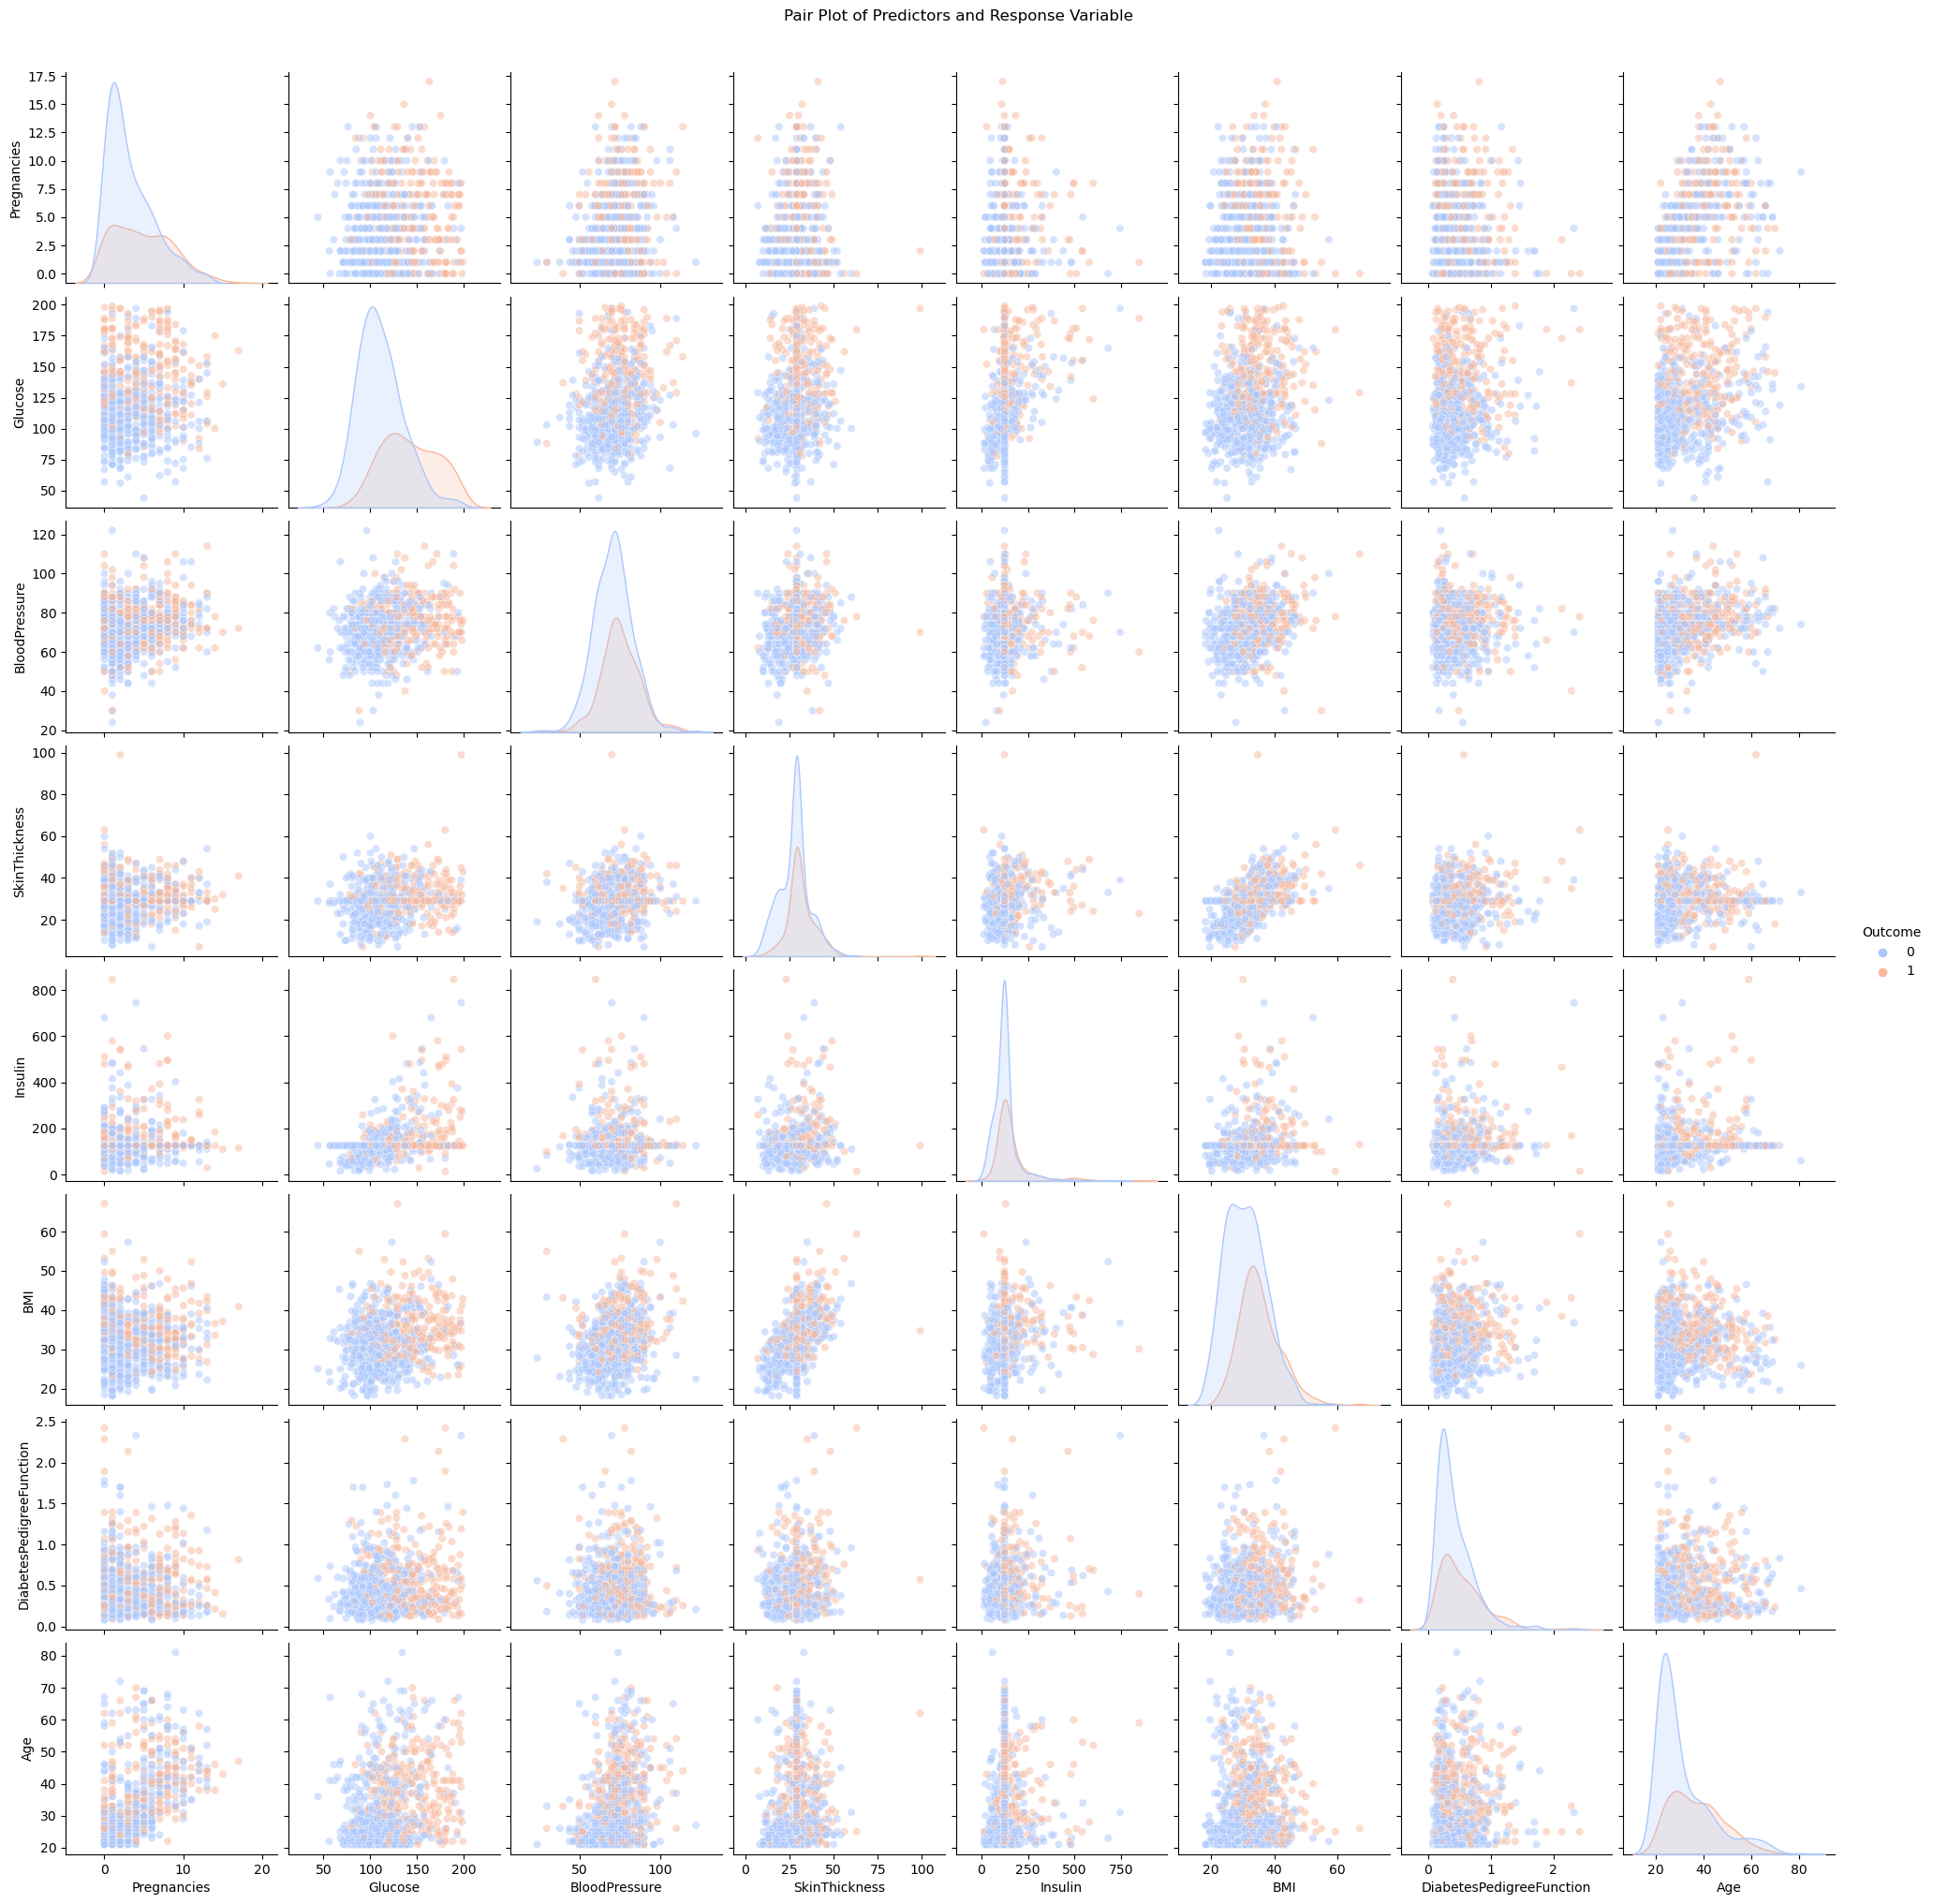

In [6]:
# pair plot
sns.pairplot(df_clean, hue="Outcome", palette="coolwarm", diag_kind="kde", plot_kws={'alpha': 0.5})
plt.suptitle('Pair Plot of Predictors and Response Variable', y=1.02)
plt.show()

Our focus was primarily on the diagonal plots, which display the Kernel Density Estimate of each variable, grouped by diabetes status: positive cases (orange) and negative cases (blue)

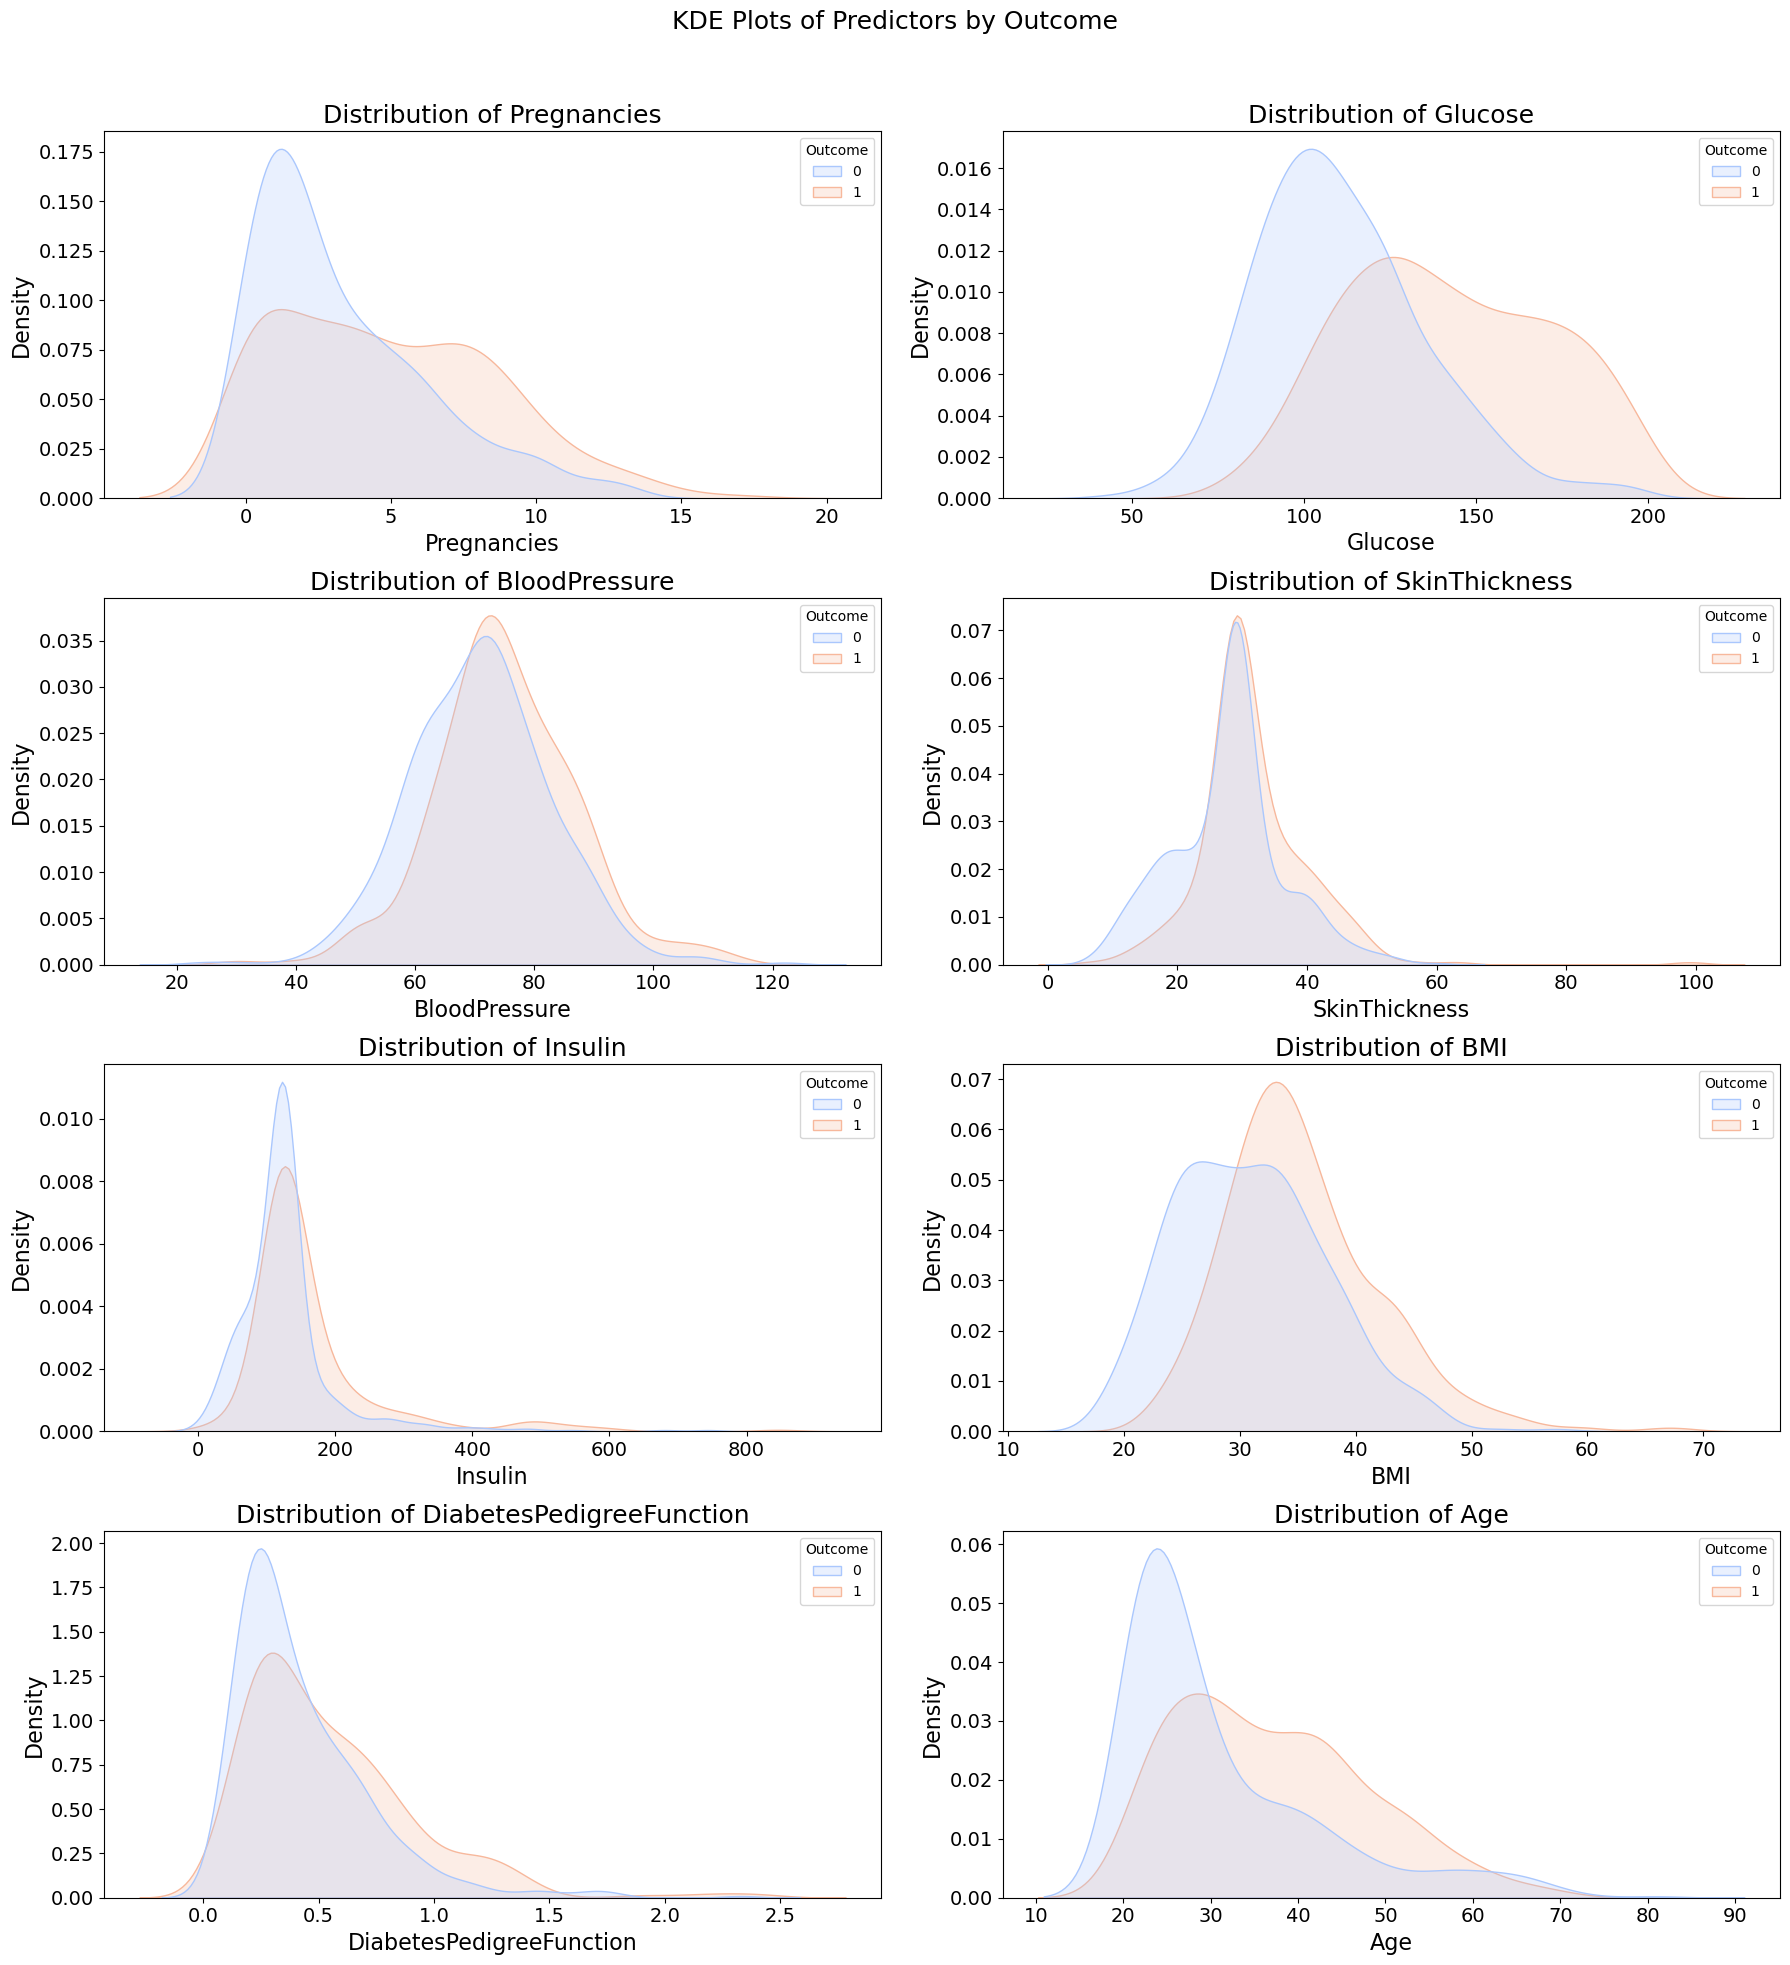

In [7]:
# diagonal plots on pair plot
features = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
            "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

fig, axes = plt.subplots(4, 2, figsize=(18, 20))
fig.suptitle('KDE Plots of Predictors by Outcome', fontsize=18)

for i, feature in enumerate(features):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data=df_clean, x=feature, hue="Outcome", fill=True, common_norm=False, ax=ax, palette="coolwarm")
    ax.set_title(f'Distribution of {feature}', fontsize=18)
    ax.set_xlabel(feature, fontsize=16)
    ax.set_ylabel("Density", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Some preliminary conclusions can be drawn: 
1.	All features demonstrate a positive association with the response variable.
2.	Women with a higher number of pregnancies are more likely to be diagnosed with diabetes 
3.	Diabetic instances tend to have higher glucose levels (>120 mg/dL), whereas non-diabetic individuals exhibit a lower distribution of glucose values. 
4.	Diabetic instances generally have higher BMI values. 
5.	The proportion of Diabetic instances is also higher in the older age group (>50 years), whereas non-diabetic instances are more prevalent among younger age groups. 
6.	Diabetic instances have a higher density in the region with higher Diabetes Pedigree Function scores (>0.6). 
7.	In contrast, the distributions of Blood Pressure, Skin Thickness, and Insulin exhibit considerable overlap between the positive and negative cases, suggesting they may contribute less to the classification


### 2.2 Correlation Heatmap

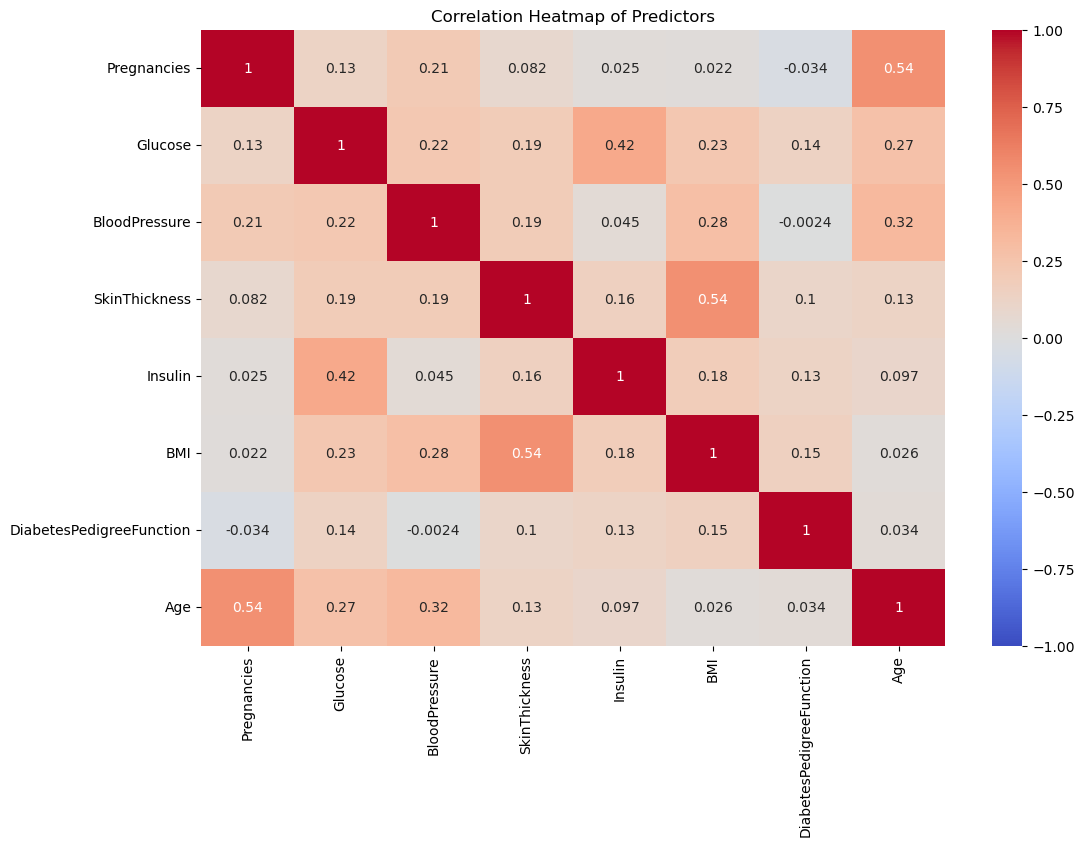

In [8]:
heat_df = df_clean.drop("Outcome", axis="columns")
plt.figure(figsize=(12, 8))
correlation_matrix = heat_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Predictors')
plt.show()

From the heatmap, it can be observed that most features exhibit weak correlations with each other, suggesting minimal multicollinearity issues. However, the relatively strong correlations between “SkinThickness” and “BMI”, as well as “Age” and “Pregnancies”, are noteworthy. For a linear model such as logistic regression, it is essential to address multicollinearity. We opted to use Ridge regularization, which shrinks the coefficients and helps stabilize the model. 

## Part 3: Modeling

### 3.1	Data Splitting

To ensure that the original class distribution is maintained in both the training and testing datasets, we employed a stratified data splitting strategy rather than a purely random split. 

In [9]:
# Check out class distribution - imbalance
df_clean.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [10]:
# train/test set split
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

# use stratify=y, since we have inbalanced data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(614, 8) (154, 8) (614,) (154,)


### 3.2 Logistic Regression

In [11]:
# Define Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the common parameter grid for Logistic Regression 'C' (inverse of alpha)
param_grid = {'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Use F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)

# Function to perform GridSearchCV and train the model
def train_pipeline(pipeline, X_train, y_train):
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kf, scoring=f1_scorer)
    grid_search.fit(X_train, y_train)
    best_c = grid_search.best_params_['log_reg__C']
    best_f1_score = grid_search.best_score_
    print(f"Best C: {best_c}")
    print(f"Best F1 Score: {best_f1_score:.4f}")
    pipeline.set_params(log_reg__C=best_c)
    return pipeline

In [12]:
# Model 1: Standard Logistic Regression + l2 penalty
pipeline1 = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000))
])

logistic_model = train_pipeline(pipeline1, X_train, y_train)



Best C: 1
Best F1 Score: 0.6583


In [13]:
# Model 2: Polynomial Features + Logistic Regression + l2 penalty
pipeline2 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000))
])

polynomial_model = train_pipeline(pipeline2, X_train, y_train)

polynomial_model.fit(X_train, y_train)

Best C: 0.01
Best F1 Score: 0.6797


Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=0.01, max_iter=1000,
                                    solver='liblinear'))])

### 3.3 Support vector meachine

An example to explian RBF kernel

In [14]:
x_cir, y_cir = make_circles(100, factor=.1, noise=.1, random_state=10)
r = np.exp(-(x_cir[:, 0] ** 2 + x_cir[:, 1] ** 2)) 

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(x_cir[:, 0], x_cir[:, 1], r, c=y_cir, s=15, cmap='coolwarm')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(-90, 90), azip=(-180, 180));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90), IntSlider(value=30, descriptio…

Modeling

In [15]:
# Set up the parameter grid for SVM
tuned_parameters = [
    {"svm__kernel": ["rbf"], "svm__gamma": [0.1, 0.01, 0.001, 0.0001], "svm__C": [0.1, 1, 10, 100, 1000]},
    {"svm__kernel": ["linear"], "svm__C": [0.1, 1, 10, 100, 1000]}
]


# Define the pipeline with Scaler and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Grid Search Setup
grid_search = GridSearchCV(estimator=pipeline, param_grid=tuned_parameters, cv=kf, scoring='f1')

# Train model
grid_search.fit(X_train, y_train)

# print the best parameters and cross-validation score
print("Best parameters set found on the training set:")
print(grid_search.best_params_)
print(f"Best F1 score: {grid_search.best_score_}")


# Save the best model
svm_model = grid_search.best_estimator_
svm_model.fit(X_train, y_train)

Best parameters set found on the training set:
{'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Best F1 score: 0.6603046530400126


Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(C=100, gamma=0.001))])

### 3.3 Random Forest

Modeling

In [16]:
# parameter grid 
param_grid = {
    "n_estimators": [100, 200, 300, 400],  
    "max_depth": [10, 15, 20, None],       
    "min_samples_split": [5, 10, 15],      
    'min_samples_leaf': [2, 4, 6],        
}

# Grid search setup
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, cv=kf, scoring='f1', n_jobs=-1)


# train model
grid_search.fit(X_train, y_train)

# Output the best parameters and cross-validation score
print("Best parameters set found on the training set:")
print(grid_search.best_params_)
print(f"Best F1 score (Cross-Validation): {grid_search.best_score_:.4f}")

# Save the best model 
rf_model = grid_search.best_estimator_
rf_model.fit(X_train, y_train)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


KeyboardInterrupt: 

Feature importance plot

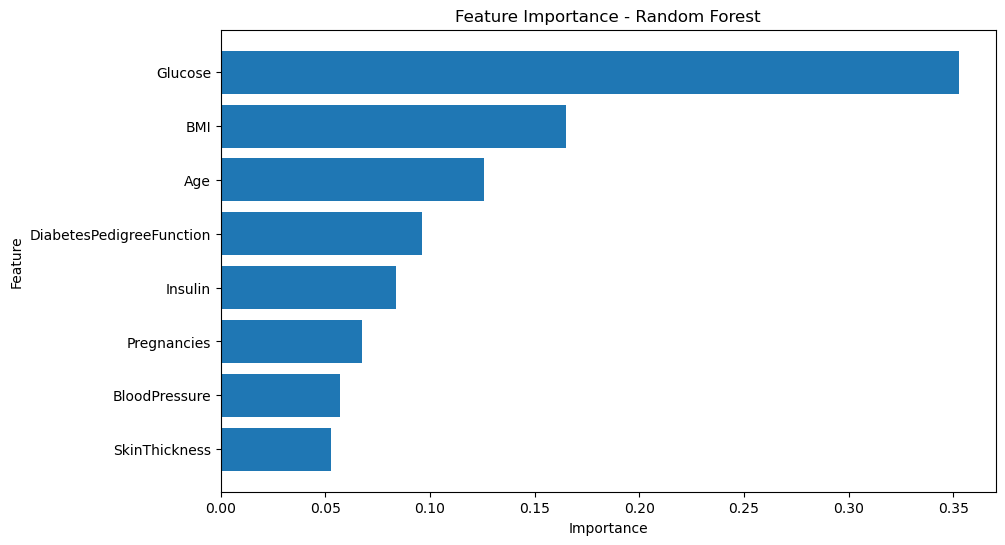

In [ ]:
feature_importances = rf_model.feature_importances_
features = X_train.columns


importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks()
plt.gca().invert_yaxis()
plt.show()


### 3.4 Neural Network

The neural network implemented in this study is a fully connected feedforward network with a hidden layer. It consists of an input layer with 8 neurons representing the predictor variables, a single hidden layer with 4 neurons utilizing the ReLU activation function to introduce non-linearity, and an output layer with 2 neurons that produce the non-normalized logits for the binary classification task (diabetic vs. non-diabetic).

In [ ]:
torch.manual_seed(42)

# Transfer to numpy array first
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Further split the training set into training and validation set use stratify sampling
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_val_scaled = scaler.transform(X_val)  
X_test_scaled = scaler.transform(X_test) 


# Transfer to tensor
device = 'cpu'
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)


In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(552, 8) (62, 8) (154, 8)
(552,) (62,) (154,)


Modeling training

In [ ]:
# Define neural networ model
class NN(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(NN, self).__init__()
        self.layers = nn.Sequential(
            # from input layer(8) to hidden layer(4)
            nn.Linear(input_dims, input_dims // 2),  # W[8, 4] b[4]
            # use ReLU as activate function
            nn.ReLU(),
            # from hidden layer(4) to output layer(2)
            nn.Linear(input_dims // 2, output_dims)  # W[4, 2] b[2]
        )

    def forward(self, x):
        return self.layers(x)

We will save the model with best validation score for further use

In [ ]:
torch.manual_seed(42)

model = NN(8, 2)

# set learining rate
learning_rate = 1e-3 

# set training epochs
epochs = 4000

# batch size
batch_size = 64 

# initialize optimizer: 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# initialized loss function: 
loss_func = torch.nn.CrossEntropyLoss()

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.long())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Store loss and F1 scores
train_losses = []
val_f1_scores = []
max_val_f1 = 0

# Traning
for epoch in range(epochs):
    model.train() 
    epoch_loss = 0

        # Iterate through all batches in the training data
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred_tensor = model(X_batch)
        loss = loss_func(y_pred_tensor, y_batch)

        # Backward pass and parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        epoch_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation evaluation
    model.eval()  
    with torch.no_grad():
        y_val_pred_tensor = model(X_val_tensor)
        y_val_pred = torch.argmax(y_val_pred_tensor, dim=-1)
        val_f1 = f1_score(y_val_tensor.numpy(), y_val_pred.numpy())
        val_f1_scores.append(val_f1)

        # Save the model if validation F1 score improves
        if val_f1 > max_val_f1:
            max_val_f1 = val_f1
            # save the best model
            torch.save(model.state_dict(), "best_model.pth")
    
    # Print metrics every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch + 1}/{epochs}: Loss = {avg_loss:.4f}, Validation F1 = {val_f1:.4f}")

# Final metrics
print(f"Best Validation F1 Score: {max_val_f1:.4f}")

Epoch 1/4000: Loss = 0.7376, Validation F1 = 0.1333
Epoch 501/4000: Loss = 0.4249, Validation F1 = 0.6667
Epoch 1001/4000: Loss = 0.4164, Validation F1 = 0.6341
Epoch 1501/4000: Loss = 0.4101, Validation F1 = 0.6341
Epoch 2001/4000: Loss = 0.4096, Validation F1 = 0.6341
Epoch 2501/4000: Loss = 0.4109, Validation F1 = 0.6341
Epoch 3001/4000: Loss = 0.4165, Validation F1 = 0.6341
Epoch 3501/4000: Loss = 0.4091, Validation F1 = 0.6341
Best Validation F1 Score: 0.8000


Plot training loss and validation F1 score

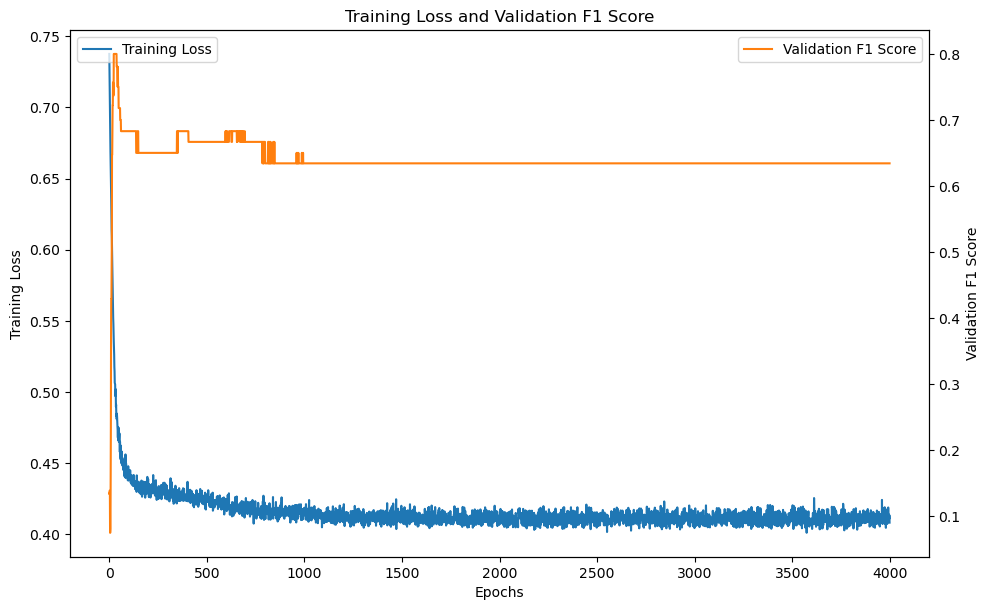

In [ ]:
epochs_range = range(epochs)

# training loss on the first y-axis 
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training Loss")
ax1.plot(epochs_range, train_losses, label="Training Loss")
ax1.tick_params(axis="y")

# validation F1 score on the second y-axis 
ax2 = ax1.twinx()
ax2.set_ylabel("Validation F1 Score")
ax2.plot(epochs_range, val_f1_scores, label="Validation F1 Score", color="tab:orange", linestyle='-')
ax2.tick_params(axis="y")


fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# Add a title and legends
plt.title("Training Loss and Validation F1 Score")

# Display the plot
plt.show()

Try to enhance the model performance by add hidden layer

In [ ]:
class BetterNN(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(BetterNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dims, input_dims),  # More nodes in the first layer
            nn.ReLU(),
            nn.Linear(input_dims, input_dims // 2),  # Add one more hidden layer
            nn.ReLU(),
            nn.Linear(input_dims // 2, output_dims)
        )
    
    def forward(self, x):
        return self.layers(x)

In [ ]:
torch.manual_seed(42)

model = BetterNN(8, 2)

# set learining rate
learning_rate = 1e-3 

# set training epochs
epochs = 4000

# batch size
batch_size = 64 

# initialize optimizer: 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# initialized loss function: 
loss_func = torch.nn.CrossEntropyLoss()

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.long())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Store loss and F1 scores
train_losses = []
val_f1_scores = []
max_val_f1 = 0

# Traning
for epoch in range(epochs):
    model.train() 
    epoch_loss = 0

        # Iterate through all batches in the training data
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred_tensor = model(X_batch)
        loss = loss_func(y_pred_tensor, y_batch)

        # Backward pass and parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        epoch_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation evaluation
    model.eval()  
    with torch.no_grad():
        y_val_pred_tensor = model(X_val_tensor)
        y_val_pred = torch.argmax(y_val_pred_tensor, dim=-1)
        val_f1 = f1_score(y_val_tensor.numpy(), y_val_pred.numpy())
        val_f1_scores.append(val_f1)

        # Save the model if validation F1 score improves
        if val_f1 > max_val_f1:
            max_val_f1 = val_f1
    
    # Print metrics every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch + 1}/{epochs}: Loss = {avg_loss:.4f}, Validation F1 = {val_f1:.4f}")

# Final metrics
print(f"Best Validation F1 Score: {max_val_f1:.4f}")

Epoch 1/4000: Loss = 0.6416, Validation F1 = 0.0000
Epoch 501/4000: Loss = 0.3427, Validation F1 = 0.5714
Epoch 1001/4000: Loss = 0.3278, Validation F1 = 0.5455
Epoch 1501/4000: Loss = 0.3007, Validation F1 = 0.5116
Epoch 2001/4000: Loss = 0.2936, Validation F1 = 0.5116
Epoch 2501/4000: Loss = 0.2883, Validation F1 = 0.4762
Epoch 3001/4000: Loss = 0.2801, Validation F1 = 0.4762
Epoch 3501/4000: Loss = 0.2746, Validation F1 = 0.4762
Best Validation F1 Score: 0.7568


The result is Even worse than before.. So we keep using the initial model `NN`.

## Part 4: Evaluation

/opt/anaconda3/envs/py_env/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/py_env/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/py_env/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/py_env/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


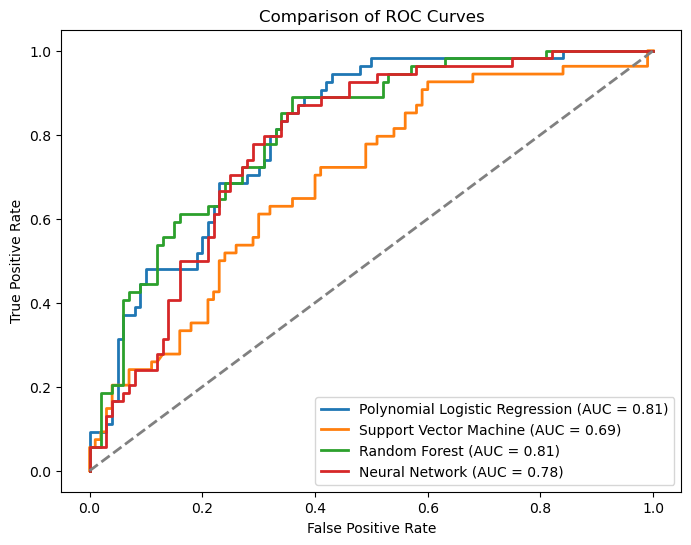

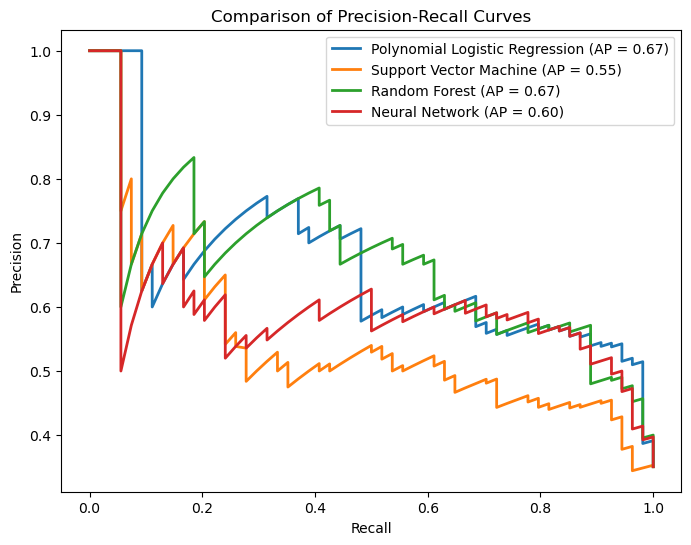

                                Accuracy  F1 Score  Precision    Recall  \
Polynomial Logistic Regression  0.714286  0.592593   0.592593  0.592593   
Support Vector Machine          0.655844  0.475248   0.510638  0.444444   
Random Forest                   0.753247  0.612245   0.681818  0.555556   
Neural Network                  0.707792  0.526316   0.609756  0.462963   

                                 AUC-ROC   AUC-PRC  
Polynomial Logistic Regression  0.809074  0.665983  
Support Vector Machine          0.693981  0.552629  
Random Forest                   0.810741  0.673673  
Neural Network                  0.781481  0.604803  


In [ ]:
def get_metrics_and_curves(model, X_test, y_test):
    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_score_val = precision_score(y_test, y_pred)
    recall_score_val = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    average_precision = average_precision_score(y_test, y_proba)
    
    metrics = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision_score_val,
        'recall': recall_score_val,
        'roc_auc': roc_auc,
        'average_precision': average_precision,
        'confusion_matrix': conf_matrix
    }
    curves = {
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve
    }
    return metrics, curves

def get_metrics_and_curves_nn(model_path, model, X_test_tensor, y_test_tensor):
    # Load the best model's weights
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        y_test_pred_tensor = model(X_test_tensor)
        y_test_proba = torch.softmax(y_test_pred_tensor, dim=1)[:, 1].numpy()
        y_pred = torch.argmax(y_test_pred_tensor, dim=1).numpy()
    y_test_true = y_test_tensor.numpy()
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test_true, y_pred)
    f1 = f1_score(y_test_true, y_pred)
    precision_score_val = precision_score(y_test_true, y_pred)
    recall_score_val = recall_score(y_test_true, y_pred)
    conf_matrix = confusion_matrix(y_test_true, y_pred)
    fpr, tpr, _ = roc_curve(y_test_true, y_test_proba)
    roc_auc = auc(fpr, tpr)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test_true, y_test_proba)
    average_precision = average_precision_score(y_test_true, y_test_proba)
    
    metrics = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision_score_val,
        'recall': recall_score_val,
        'roc_auc': roc_auc,
        'average_precision': average_precision,
        'confusion_matrix': conf_matrix
    }
    curves = {
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve
    }
    return metrics, curves

# Initialize models if not already done
# Ensure SVM is initialized with probability=True
svm_model = SVC(kernel='rbf', C=100, gamma=0.001, probability=True)
svm_model.fit(X_train, y_train)

# Collect metrics and curves
models_info = {}

# Polynomial Logistic Regression
metrics_plr, curves_plr = get_metrics_and_curves(polynomial_model, X_test, y_test)
models_info['Polynomial Logistic Regression'] = {'metrics': metrics_plr, 'curves': curves_plr}

# Support Vector Machine
metrics_svm, curves_svm = get_metrics_and_curves(svm_model, X_test, y_test)
models_info['Support Vector Machine'] = {'metrics': metrics_svm, 'curves': curves_svm}

# Random Forest
metrics_rf, curves_rf = get_metrics_and_curves(rf_model, X_test, y_test)
models_info['Random Forest'] = {'metrics': metrics_rf, 'curves': curves_rf}

# Neural Network
model_nn = NN(8, 2)
metrics_nn, curves_nn = get_metrics_and_curves_nn("best_model.pth", model_nn, X_test_tensor, y_test_tensor)
models_info['Neural Network'] = {'metrics': metrics_nn, 'curves': curves_nn}

plt.figure(figsize=(8, 6))
for model_name, info in models_info.items():
    plt.plot(info['curves']['fpr'], info['curves']['tpr'], lw=2, label=f"{model_name} (AUC = {info['metrics']['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')
plt.title('Comparison of ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(8, 6))
for model_name, info in models_info.items():
    plt.plot(info['curves']['recall_curve'], info['curves']['precision_curve'], lw=2, label=f"{model_name} (AP = {info['metrics']['average_precision']:.2f})")
plt.title('Comparison of Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.show()


metrics_df = pd.DataFrame({
    model_name: {
        'Accuracy': info['metrics']['accuracy'],
        'F1 Score': info['metrics']['f1_score'],
        'Precision': info['metrics']['precision'],
        'Recall': info['metrics']['recall'],
        'AUC-ROC': info['metrics']['roc_auc'],
        'AUC-PRC': info['metrics']['average_precision']
    }
    for model_name, info in models_info.items()
}).T

print(metrics_df)

Random Forest outperforms the other models across most metrics, except for recall, where it is slightly outperformed by Logistic Regression. This suggests that Random Forest is the most robust model for identifying diabetic instances in general.